## Question 1: Hierarchical Models

A company has found that the widgets they manufacture contain some mysterious radioactive material. The company produced 100 widgets in 35 days before they realised the widgets contained radioactive material. Then it took 14 days before an investigation was started. The investigation took 90 days. During the investigation, a company worker would visit the location where a widget was shipped to, and measured the radioactive material in the widget. Only one measurement of the radioactive material was performed per widget.

The company has asked you whether you can infer the rate of radioactive decay of the material in the widgets. They know that the amount of radioactive material $N$ at any time $t$ is
$$N = N_{0}\exp(-\alpha[t-t_{0}])$$
where 
$N$
 is measured in grams and 
$t$ is measured in seconds. They also know that the detectors they use to measure the amount of radioactive material reports uncertainties that are normally distributed.

The company does not know how much radioactive material was initially put into each widget, but they know that the amount is different for each widget. However, they do know that the initial amount of radioactive material must be less than 20 grams in every widget.

Unfortunately, the company also does not know when each widget was made. All they can tell you is that all 100 widgets were made in 35 days. You can see how this careless operation has led to such a problematic situation!

### Task 1

Infer the decay rate 
$\alpha$
 for the mysterious radioactive material.



In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
N_widgets = 100
N_initial_max = 20
data = pd.read_csv('/Users/admzlm4/Documents/Assignments/DAML/decay.csv')
t_measured = np.array(data['time_measured_in_seconds'])
days_to_seconds = 24 * 60 * 60
t_initial_max = 35 * days_to_seconds
N_measured = np.array(data['grams_measured'])
sigma_N_measured = np.array(data['uncertainty_in_grams_measured'])
alpha = np.random.uniform()*1e-6

import os
import logging
import pickle
import arviz as az
import pystan as stan

def load_stan_model(path, cached_path=None, recompile=False, overwrite=True,
    verbose=True):
    r"""
    Load a Stan model from a file. If a cached file exists, use it by default.

    :param path:
        The path of the Stan model.

    :param cached_path: [optional]
        The path of the cached Stan model. By default this will be the same  as
        :path:, with a `.cached` extension appended.

    :param recompile: [optional]
        Recompile the model instead of using a cached version. If the cached
        version is different from the version in path, the model will be
        recompiled automatically.
    """

    cached_path = cached_path or "{}.cached".format(path)

    with open(path, "r") as fp:
        model_code = fp.read()

    while os.path.exists(cached_path) and not recompile:
        with open(cached_path, "rb") as fp:
            model = pickle.load(fp)

        if model.model_code != model_code:
            if verbose:
                logging.warn("Cached model at {} differs from the code in {}; "\
                            "recompiling model".format(cached_path, path))
            recompile = True
            continue

        else:
            if verbose:
                logging.info("Using pre-compiled model from {}".format(cached_path)) 
            break

    else:
        model = stan.StanModel(model_code=model_code)

        # Save the compiled model.
        if not os.path.exists(cached_path) or overwrite:
            with open(cached_path, "wb") as fp:
                pickle.dump(model, fp)


    return model


def sampling_kwds(**kwargs):
    r"""
    Prepare a dictionary that can be passed to Stan at the sampling stage.
    Basically this just prepares the initial positions so that they match the
    number of chains.
    """

    kwds = dict(chains=4)
    kwds.update(kwargs)

    if "init" in kwds:
        kwds["init"] = [kwds["init"]] * kwds["chains"]

    return kwds

In [ ]:
model = load_stan_model("decay.stan")

# Data.
data_dict = dict(
    N_widgets=N_widgets,
    t_initial_max=t_initial_max,
    t_measured=t_measured,
    N_measured=N_measured,
    sigma_N_measured=sigma_N_measured,
    N_initial_max=N_initial_max,
)

init_dict = dict(alpha=alpha)

# Run optimisation.
opt_stan = model.optimizing(
    data=data_dict,
    init=init_dict
)

# Run sampling.
samples = model.sampling(**sampling_kwds(
    chains=2,
    iter=100,
    data=data_dict,
    init=opt_stan
))

INFO:root:Using pre-compiled model from decay.stan.cached


## Question 3

The following files contain images of hand-written digits:

- training set images
- test set images

YOUR FIRST TASK

You will recall that an autoencoder is a neural network with a specific structure. Your task is to train an autoencoder using these images. Specify the network architecture in as much detail as you would explain a generative model.

Demonstrate that the latent space of your autoencoder smoothly represents digits by inputting the test-set images and recording the latent space values found for each image. Plot the latent space values coloured by the known test set labels.

YOUR SECOND TASK

Is to use the autoencoder to generate new images of digits that have not been drawn by a human! Create a grid of latent space values. At each grid point, use the decoder to make a prediction of an image. Show that image on a grid point. Repeat this process until you have smoothly mapped out (two dimensions of) the latent space.

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class Sampling(layers.Layer):
    
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

#Build the encoder
latent_dim = 2
encoder_inputs = keras.Input(shape=(28,28,1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")



#Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")





class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=10, batch_size=32)

Epoch 1/10
2188/2188 [==============================] - 44s 20ms/step - loss: 216.9139 - reconstruction_loss: 192.2159 - kl_loss: 3.1729
Epoch 2/10
2188/2188 [==============================] - 44s 20ms/step - loss: 176.5521 - reconstruction_loss: 164.8253 - kl_loss: 4.9743
Epoch 3/10
2188/2188 [==============================] - 47s 22ms/step - loss: 160.0564 - reconstruction_loss: 153.1159 - kl_loss: 5.8250
Epoch 4/10
2188/2188 [==============================] - 48s 22ms/step - loss: 156.6697 - reconstruction_loss: 149.9764 - kl_loss: 6.0247
Epoch 5/10
2188/2188 [==============================] - 56s 25ms/step - loss: 154.7286 - reconstruction_loss: 148.2165 - kl_loss: 6.1177
Epoch 6/10
2188/2188 [==============================] - 55s 25ms/step - loss: 152.7240 - reconstruction_loss: 147.0674 - kl_loss: 6.1717
Epoch 7/10
2188/2188 [==============================] - 52s 24ms/step - loss: 152.5048 - reconstruction_loss: 146.3255 - kl_loss: 6.2203
Epoch 8/10
2188/2188 [===================

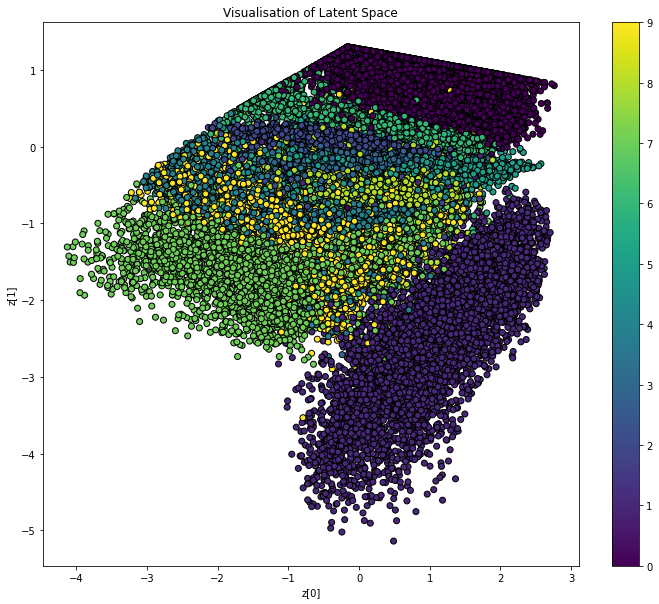

In [6]:
import matplotlib.pyplot as plt
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels,edgecolors='black')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title('Visualisation of Latent Space')
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

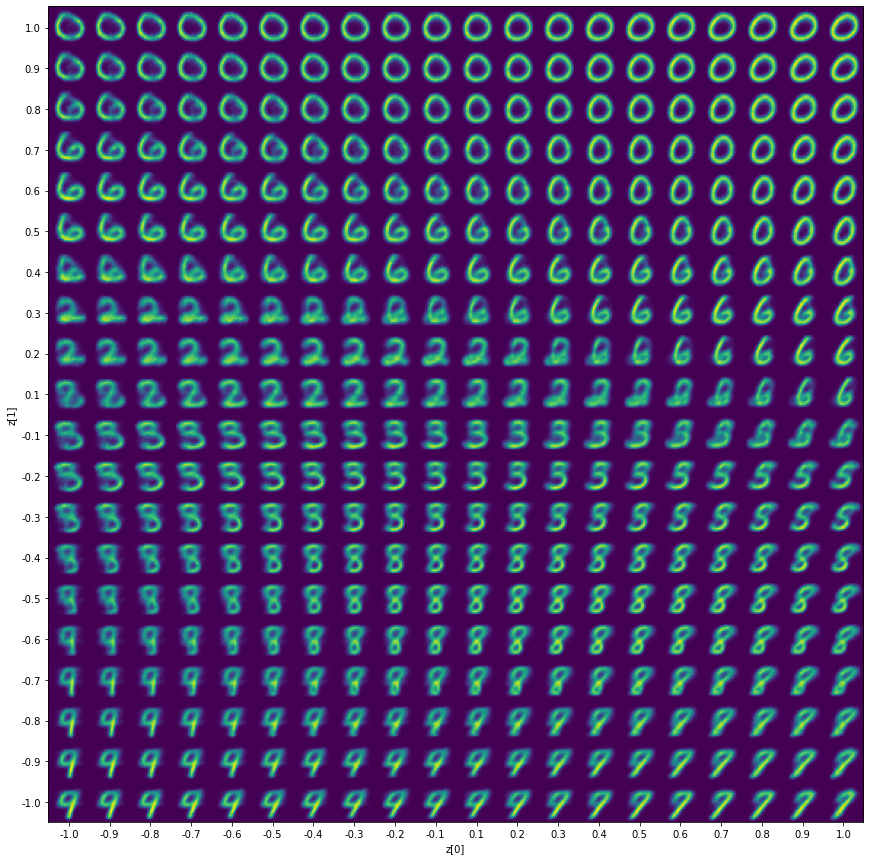

In [47]:
def plot_latent_space(vae, n=20, figsize=15):
    # display a n*n 2D plot of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()


plot_latent_space(vae)

## Question 4

The dataset (download here; 200 MB) contains 25,753 coloured images (g, r, and i band) each 69 x 69 pixels in size. There are 10 classes of galaxies:
Full dataset (25753 images)

├── Class 0 (3461 images): Disk, Face-on, No Spiral

├── Class 1 (6997 images): Smooth, Completely round

├── Class 2 (6292 images): Smooth, in-between round

├── Class 3 (394 images): Smooth, Cigar shaped

├── Class 4 (3060 images): Disk, Edge-on, Rounded Bulge

├── Class 5 (17 images): Disk, Edge-on, Boxy Bulge

├── Class 6 (1089 images): Disk, Edge-on, No Bulge

├── Class 7 (1932 images): Disk, Face-on, Tight Spiral

├── Class 8 (1466 images): Disk, Face-on, Medium Spiral

└── Class 9 (1045 images): Disk, Face-on, Loose Spiral

You will need h5py to load these data

Train five classifiers (different techniques) to classify galaxies. You can choose these techniques, but you should choose them to be appropriate for the problem and suitable to give good results on this data set. Ensure that you split your data set appropriately to train, validation (where appropriate), and test.

Evaluate these classification techniques and make a recommendation for which is most suitable. As part of evaluating performance, you should consider and discuss things like precision, recall, confusion matrices, biased/unbiased training sets, and cross-validation.




**Five different classifiers from the scikit-learn package were trained in order to classify the aforementioned images into one of ten different classes, whose labels are represented by integers ranging from 0 to 9 as indicated above. The chosen classifiers were deemed to be appropriate for the classification of images, and were as follows:**
1. Random Forest Classifier
2. Decision Tree Classifier
3. Gaussian Naive Bayes Classifier
4. K Nearest Neighbours Classifier
5. SGD Classifier 
**A classification report and a confusion matrix have been produced for each of the five classifiers. The classification report provides a more detailed overview of the process followed by each algorithm to categorise the images. It includes information on metrics such as the precision, recall, and f1 score of each classification made by the model. In addition to this, it includes a measure of the accuracy of the model. The confusion matrix provides a class-by-class breakdown of correct and incorrect classifications made by each model. Based on these metrics, one can determine the most appropriate model that can be used to classify the images of these galaxies. It should be noted that the data had been split into training and test sets in an 85-15 ratio (i.e. 85% of the data was used for training the models, while the remaining 15% was used as the test set). This ratio was kept consistent for all five models**

In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

  
with h5py.File('/Users/admzlm4/Desktop/Galaxy10.h5', 'r') as fp:
    images = np.array(fp['images'])
    labels = np.array(fp['ans'])
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.15)

#Normalise the data
X_train = X_train/255.0
X_test = X_test/255.0

nsamples, nx, ny, nz = X_train.shape

X_train_clf = X_train.reshape((nsamples, nx*ny*nz))


nsamples, nx, ny, nz = X_test.shape
X_test_clf = X_test.reshape((nsamples, nx*ny*nz))


# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train_clf, y_train)
y_pred = model.predict(X_test_clf)

print(accuracy_score(y_pred, y_test))
print(classification_report(y_pred, y_test))
confusion_matrix(y_pred, y_test)

(18517, 69, 69, 3) (3268, 69, 69, 3)
(18517, 14283)
(3268, 14283)
0.7019583843329253
              precision    recall  f1-score   support

           0       0.53      0.45      0.49       588
           1       0.94      0.78      0.85      1256
           2       0.78      0.74      0.76      1009
           3       0.07      0.57      0.12         7
           4       0.79      0.78      0.78       228
           5       0.00      0.00      0.00         0
           6       0.84      0.66      0.74       105
           7       0.25      0.60      0.35        70
           8       0.01      0.50      0.01         2
           9       0.04      1.00      0.07         3

    accuracy                           0.70      3268
   macro avg       0.42      0.61      0.42      3268
weighted avg       0.78      0.70      0.74      3268



/Users/admzlm4/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admzlm4/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admzlm4/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[265,  33,  57,   6,   5,   0,   0,  84,  93,  45],
       [ 95, 983, 153,   0,   0,   0,   0,  14,   7,   4],
       [127,  24, 750,  12,  27,   0,   1,  27,  16,  25],
       [  0,   0,   0,   4,   1,   0,   1,   0,   0,   1],
       [  7,   0,   0,  24, 177,   2,  11,   3,   3,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,   0,   2,  11,  14,   3,  69,   0,   1,   3],
       [  6,   9,   1,   0,   0,   0,   0,  42,  12,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   3]])

In [9]:
# Decision Tree Classifier 
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train_clf, y_train)
y_pred_dtc = dtc.predict(X_test_clf)
y_pred_dtc
accuracy_score(y_pred_dtc, y_test)
print(classification_report(y_pred_dtc, y_test))
confusion_matrix(y_pred_dtc, y_test)

              precision    recall  f1-score   support

           0       0.30      0.30      0.30       502
           1       0.67      0.66      0.67      1062
           2       0.57      0.56      0.56       980
           3       0.16      0.16      0.16        55
           4       0.54      0.58      0.56       207
           5       0.00      0.00      0.00         4
           6       0.63      0.51      0.57       101
           7       0.25      0.25      0.25       174
           8       0.21      0.22      0.21       128
           9       0.06      0.09      0.07        55

    accuracy                           0.51      3268
   macro avg       0.34      0.33      0.34      3268
weighted avg       0.51      0.51      0.51      3268



array([[150,  96, 117,  12,  13,   0,   2,  52,  37,  23],
       [ 99, 703, 206,   0,   5,   0,   4,  22,  16,   7],
       [127, 198, 546,   9,  31,   1,   5,  25,  18,  20],
       [  6,   0,  11,   9,  15,   0,   7,   0,   3,   4],
       [ 18,  10,  21,   9, 121,   3,  10,   4,   3,   8],
       [  0,   1,   0,   0,   3,   0,   0,   0,   0,   0],
       [  4,   0,   6,   7,  29,   0,  52,   0,   0,   3],
       [ 45,  20,  27,   5,   1,   0,   1,  43,  26,   6],
       [ 34,  13,  18,   4,   3,   0,   0,  21,  28,   7],
       [ 19,   8,  11,   2,   3,   1,   1,   3,   2,   5]])

In [10]:
# Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train_clf, y_train)
y_pred_nb = nb.predict(X_test_clf)
accuracy_score(y_pred_nb, y_test)
print(classification_report(y_pred_nb, y_test))
confusion_matrix(y_pred_nb, y_test)

              precision    recall  f1-score   support

           0       0.03      0.20      0.05        75
           1       0.14      0.50      0.22       288
           2       0.36      0.50      0.42       688
           3       0.25      0.08      0.13       166
           4       0.23      0.32      0.26       161
           5       0.00      0.00      0.00        59
           6       0.77      0.09      0.16       683
           7       0.15      0.30      0.20        82
           8       0.57      0.08      0.14       920
           9       0.06      0.03      0.04       146

    accuracy                           0.23      3268
   macro avg       0.25      0.21      0.16      3268
weighted avg       0.44      0.23      0.21      3268



array([[ 15,  32,  14,   2,   2,   0,   0,   6,   3,   1],
       [ 26, 145, 100,   1,   6,   0,   0,   2,   2,   6],
       [ 51, 234, 346,  10,  21,   0,   0,  13,   9,   4],
       [ 32,  24,  36,  14,  32,   0,   8,   9,   4,   7],
       [ 19,  45,  24,   2,  51,   1,   1,   8,   2,   8],
       [  5,  13,   8,   2,  21,   0,   6,   2,   0,   2],
       [ 83, 219, 161,  19,  72,   4,  63,  16,  22,  24],
       [ 18,  17,  18,   0,   0,   0,   0,  25,   2,   2],
       [229, 278, 216,   5,   9,   0,   1,  82,  76,  24],
       [ 24,  42,  40,   2,  10,   0,   3,   7,  13,   5]])

In [11]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn.fit(X_train_clf, y_train)
y_pred_knn = knn.predict(X_test_clf)
accuracy_score(y_pred_knn, y_test)
print(classification_report(y_pred_knn, y_test))
confusion_matrix(y_pred_knn, y_test)

              precision    recall  f1-score   support

           0       0.34      0.46      0.39       371
           1       0.93      0.68      0.78      1445
           2       0.76      0.69      0.72      1055
           3       0.30      0.55      0.39        31
           4       0.71      0.77      0.74       207
           5       0.00      0.00      0.00         0
           6       0.71      0.79      0.75        73
           7       0.18      0.42      0.26        73
           8       0.04      0.50      0.07        10
           9       0.02      0.67      0.05         3

    accuracy                           0.66      3268
   macro avg       0.40      0.55      0.41      3268
weighted avg       0.76      0.66      0.70      3268



/Users/admzlm4/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admzlm4/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admzlm4/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[171,  31,  33,   7,  14,   0,   2,  47,  40,  26],
       [156, 977, 196,   0,   6,   0,   1,  49,  44,  16],
       [148,  38, 729,  10,  30,   0,   1,  39,  27,  33],
       [  1,   0,   0,  17,   6,   0,   3,   1,   2,   1],
       [  1,   0,   1,  18, 160,   3,  17,   2,   2,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   5,   8,   2,  58,   0,   0,   0],
       [ 22,   3,   3,   0,   0,   0,   0,  31,  13,   1],
       [  3,   0,   0,   0,   0,   0,   0,   1,   5,   1],
       [  0,   0,   1,   0,   0,   0,   0,   0,   0,   2]])

In [12]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_clf, y_train)
y_pred_sgd = sgd_clf.predict(X_test_clf)
accuracy_score(y_pred_sgd, y_test)
print(classification_report(y_pred_sgd, y_test))
confusion_matrix(y_pred_sgd, y_test)


              precision    recall  f1-score   support

           0       0.63      0.27      0.38      1149
           1       0.24      0.49      0.32       515
           2       0.54      0.40      0.46      1307
           3       0.04      0.09      0.05        22
           4       0.48      0.70      0.57       152
           5       0.00      0.00      0.00         0
           6       0.44      0.52      0.48        69
           7       0.11      0.47      0.17        38
           8       0.02      0.67      0.03         3
           9       0.04      0.23      0.06        13

    accuracy                           0.39      3268
   macro avg       0.25      0.39      0.25      3268
weighted avg       0.51      0.39      0.41      3268



/Users/admzlm4/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admzlm4/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admzlm4/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[314, 301, 235,   9,  28,   1,  24, 114,  83,  40],
       [ 57, 253, 174,   3,  13,   0,   3,   5,   5,   2],
       [115, 480, 524,  32,  54,   0,  12,  32,  29,  29],
       [  1,   1,  10,   2,   4,   0,   2,   0,   0,   2],
       [  4,  10,  13,   6, 107,   2,   5,   0,   1,   4],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  3,   1,   5,   4,  16,   2,  36,   0,   1,   1],
       [  5,   3,   1,   0,   0,   0,   0,  18,  10,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   2,   1],
       [  3,   0,   1,   1,   2,   0,   0,   1,   2,   3]])

**The F1 score of